In [1]:
%%capture
import os
import matplotlib.pyplot as plt
from sklearn.datasets import load_iris
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
import numpy as np
! pip install cvxpy
import cvxpy as cp
from tqdm import tqdm
import pandas as pd

In [2]:
actual_path = os.getcwd()
os.chdir('/home/onyxia/work/advanced_ml_proj/data')
original_data = pd.read_csv('OnlineNewsPopularity.csv')
os.chdir(actual_path)

In [3]:
full_names = []
for name in list(original_data.columns):
    temp_name = name.split()
    full_names.append(temp_name[0])

In [4]:
original_data.columns = full_names

In [5]:
original_data.columns

Index(['url', 'timedelta', 'n_tokens_title', 'n_tokens_content',
       'n_unique_tokens', 'n_non_stop_words', 'n_non_stop_unique_tokens',
       'num_hrefs', 'num_self_hrefs', 'num_imgs', 'num_videos',
       'average_token_length', 'num_keywords', 'data_channel_is_lifestyle',
       'data_channel_is_entertainment', 'data_channel_is_bus',
       'data_channel_is_socmed', 'data_channel_is_tech',
       'data_channel_is_world', 'kw_min_min', 'kw_max_min', 'kw_avg_min',
       'kw_min_max', 'kw_max_max', 'kw_avg_max', 'kw_min_avg', 'kw_max_avg',
       'kw_avg_avg', 'self_reference_min_shares', 'self_reference_max_shares',
       'self_reference_avg_sharess', 'weekday_is_monday', 'weekday_is_tuesday',
       'weekday_is_wednesday', 'weekday_is_thursday', 'weekday_is_friday',
       'weekday_is_saturday', 'weekday_is_sunday', 'is_weekend', 'LDA_00',
       'LDA_01', 'LDA_02', 'LDA_03', 'LDA_04', 'global_subjectivity',
       'global_sentiment_polarity', 'global_rate_positive_words',
     

In [6]:
original_data.drop(['url','timedelta'],axis=1,inplace=True)

In [7]:
original_data['shares'].describe()

count     39644.000000
mean       3395.380184
std       11626.950749
min           1.000000
25%         946.000000
50%        1400.000000
75%        2800.000000
max      843300.000000
Name: shares, dtype: float64

In [8]:
n = original_data.shape[0]
original_data['pop_cat'] = original_data['shares'].copy()
data = original_data.copy()
for i in range(n):
    if data.loc[i,'shares'] < 946.:
        data.loc[i,'pop_cat'] = 0
    elif data.loc[i,'shares'] < 1400. :
        data.loc[i,'pop_cat'] = 1
    elif data.loc[i,'shares'] < 2800. :
        data.loc[i,'pop_cat'] = 2
    elif data.loc[i,'shares'] >= 2800. :
        data.loc[i,'pop_cat'] = 3

In [9]:
def gaussian_ker(x, y, q):
    """a function to compute the gaussian kernel of two points
    -------------------------------
    inputs : 

    x : array-like, vector
    first vector for which we want to compute the kernel

    y : array-like, vector
    second vector for which we want to compute the kernel

    q : positive float,
    value of the bandwidth of the kernel

    returns:
    ker : float,
    the value of the kernel
    -------------------------------
    """

    ker = np.exp(-q*np.linalg.norm(x-y)**2)
    return ker

In [10]:
def gram_mat(X, q):
    """
    a function to compute the gram matrix of a given dataset

    ----------------------------------------
    inputs : 
    X : array-like object, must be 2D
    the data for which we want to compute the gram matrix

    q : positive float, 
    the bandwidth of the gaussian kernel
    -----------------------------------------

    returns:
    K : the gram matrix
    """
    
    norms = np.linalg.norm(X, axis=1)**2
    dot = X@X.T
    squared_euclidian_distances = norms[:, None] - 2 * dot + norms[None, :]
    K = np.exp(-squared_euclidian_distances*q)
    return K

In [11]:
def compute_seg(x, y, nb=20):
    """
    a function used to compute the segment between two points
    -----------------------------------
    Parameters : 

    x : array-like obj,
    an input, d>=2

    y : array-like obj, 
    the second input

    nb : int, 
    the number of points we want to have between the two points

    Returns : 

    segment : array-like
    an array of shape d (dimension of x), nb
    ---------------------------------------
    """
    d = x.shape[0]
    segment = np.zeros((nb, d))
    points = np.linspace(start=0., stop=1., num=nb, endpoint=True)
    
    for i in range(nb):
        t = points[i]
        segment[i, :] = (1-t) * x + t * y
        
    return segment

In [12]:
def radius(x, sample, beta, bkb, q, ker_self=1.):
    """
    compute the radius for a given instance x
    -----------------------------------------------
    Parameters : 

    x : 1-D vector,
    the input vector

    sample : matrix, 
    the whole sample, 

    beta : array-like, 
    the calculated beta

    bkb : float,
    the result of beta.T@K@beta

    ker_self : float,
    the value of the kernel of the selected instance with itself, 
    set to 1 by default as we use mostly the gaussian kernel

    returns :

    radius : float,
    the distance between the test instance and the center of the 
    sphere enclosing all the points in the Hilbert space
    -----------------------------------------------
    """
    nb_samp = sample.shape[0]
    temp_k = np.zeros(nb_samp)

    for elem in range(nb_samp):
        temp_k[elem] = gaussian_ker(x, sample[elem], q=q)
        
    return np.sqrt(ker_self - 2*np.dot(temp_k, beta) + bkb)

Application on the Iris dataset

In [13]:
target = data['pop_cat']

In [14]:
import numpy as np
import pandas as pd
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

# Prétraitement : Normaliser les données (centrage et réduction)
scaler = StandardScaler()
data_scaled = scaler.fit_transform(data)

# Initialisation de la PCA
n_components = 15  # Choisissez le nombre de composantes principales souhaitées
pca = PCA(n_components=n_components)

# Appliquer la PCA
principal_components = pca.fit_transform(data_scaled)

# Créer un DataFrame des composantes principales
columns = [f"PC{i+1}" for i in range(n_components)]
principal_df = pd.DataFrame(data=principal_components, columns=columns)

# Variance expliquée par chaque composante
print("Variance expliquée par chaque composante :", pca.explained_variance_ratio_)

# Somme de la variance expliquée
print("Variance totale expliquée :", np.sum(pca.explained_variance_ratio_))

Variance expliquée par chaque composante : [0.08025619 0.06675675 0.06062341 0.0500262  0.04552895 0.04280176
 0.04072956 0.03797126 0.03519535 0.03464405 0.0333973  0.03187181
 0.0271908  0.02325595 0.02272863]
Variance totale expliquée : 0.6329779548446851


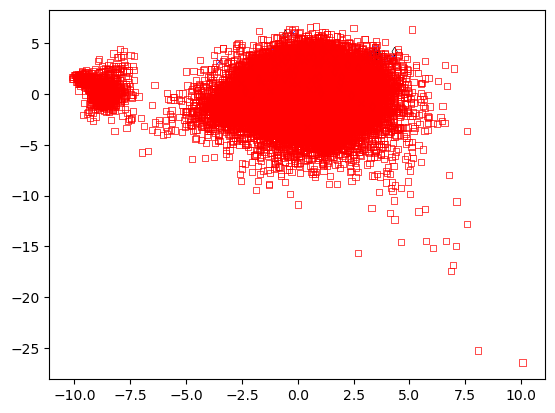

In [15]:
plt.scatter(principal_df.iloc[:50, 0], - principal_df.iloc[:50, 1], marker='x', color='blue', s=20, linewidths=0.5)
plt.scatter(principal_df.iloc[50:100, 0], - principal_df.iloc[50:100, 1], marker='d', color='black', facecolors="none", s=20, linewidths=0.5)
plt.scatter(principal_df.iloc[100:, 0], - principal_df.iloc[100:, 1], marker='s', color='red', facecolors="none", s=20, linewidths=0.5)
# plt.ylim(-1.5, 1.5)
# plt.xlim(-4, 4)
plt.show()

In [16]:
# Hyperparameters of the SVC procedure
N = n
q = 0.9
p = 0.6
C = 1

In [17]:
gram_x = gram_mat(X=principal_df, q=q)

In [ ]:
n = len(principal_df)
beta = cp.Variable(n)
gram_x += gram_x.T
gram_x /= 2
gram_x = cp.psd_wrap(gram_x)


# Formulation de l'objectif
objective = cp.Maximize(cp.sum(np.ones(n) @ beta) - cp.quad_form(beta, gram_x))

# Contraintes
constraints = [
    beta >= 0,  # 0 <= beta_j
    beta <= C,  # beta_j <= C
    cp.sum(beta) == 1  # La somme des éléments de beta doit être égale à 1
]

# Définir le problème d'optimisation
problem = cp.Problem(objective, constraints)

# Résoudre le problème
problem.solve(solver='CLARABEL')

In [ ]:
true_beta = beta.value
beta_k_beta = true_beta.T @ gram_x @ true_beta

In [ ]:
index_of_sv = []
index_of_bsv = []

for i in range(N):
    if 1e-10 < true_beta[i] and true_beta[i] < C:
        index_of_sv.append(i)
    elif true_beta[i] >= C - 1e-3:
        index_of_bsv.append(i)

print('index of sv', index_of_sv)
print('number of sv', len(index_of_sv))
print('index of bsv', index_of_bsv)
print('number of bsv', len(index_of_bsv))

In [ ]:
potential_sv = principal_df.iloc[index_of_sv, :].to_numpy()

In [ ]:
gram_x = gram_mat(X=principal_df, q=q)
gram_x += gram_x.T
gram_x /= 2
r = []
beta_k_beta = true_beta.T @ gram_x @ true_beta
for point_sv in potential_sv:
    temp_K = np.zeros(n)
    for elem in range(n):
        temp_K[elem] = gaussian_ker(point_sv, principal_df.iloc[elem, :], q=q)
    r_xi = np.sqrt(1 - 2 * np.dot(temp_K, true_beta) + beta_k_beta)
    r.append(r_xi)
rad = np.mean(r)

In [ ]:
adjacency_mat = np.zeros((n, n))

for i in tqdm(range(n)):
    for j in range(i+1, n):
        decision = True
        segment = compute_seg(x=principal_df.to_numpy()[i,:], y=principal_df.to_numpy()[j,:])
        list_of_val = []
        for point in segment:
            dist = radius(x=point, beta=true_beta, bkb=beta_k_beta, sample=principal_df.to_numpy(), q=q)
            list_of_val.append(dist)
        for value in list_of_val:
            if value > rad:
                decision = False
        
        if decision == True:
            adjacency_mat[i, j] = 1

adjacency_mat = adjacency_mat + adjacency_mat.T
adjacency_mat /= 2
for i in range(n):
    adjacency_mat[i,i] = 0

In [ ]:
import networkx as nx
G = nx.from_numpy_array(adjacency_mat)

clusters = list(nx.connected_components(G))
print('number of clusters detected', len(clusters))

In [ ]:
# Trier les clusters par taille décroissante
sorted_clusters = sorted(clusters, key=len, reverse=True)

# Afficher la taille du plus gros cluster
print(f"Taille du plus gros cluster: {len(sorted_clusters[0])}")

# Si vous voulez afficher les tailles des 5 plus gros clusters, par exemple :
top_5_clusters = sorted_clusters[:5]
for i, cluster in enumerate(top_5_clusters, start=1):
    print(f"Taille du cluster {i}: {len(cluster)}")


In [ ]:
from collections import Counter
misclassified_count = 0

# Parcourir chaque cluster
for cluster in clusters:

    if len(cluster) > 1:
        # Extraire les labels des points dans le cluster
        cluster_labels = [target[i] for i in cluster]
        
        # Trouver le label majoritaire dans le cluster
        majority_label = Counter(cluster_labels).most_common(1)[0][0]
        
        # Compter les misclassifications dans ce cluster
        for i in cluster:
            if target[i] != majority_label:
                misclassified_count += 1

print(f"Nombre total de misclassifications : {misclassified_count}")
